In [1]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import re
import glob

In [2]:
# Read in Data:
data = []
for excel_path in glob.glob("EnergieUebersichtCH-*"):
    data.append(pd.read_excel(excel_path, sheet_name='Zeitreihen0h15'))

data = pd.concat(data, axis=0, ignore_index=True)

In [3]:
data

,Unnamed: 0,Summe endverbrauchte Energie Regelblock Schweiz\nTotal energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz\nTotal energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz\nNet outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz\nGrid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie\nPositive secundary control energy,Negative Sekundär-Regelenergie\nNegative secundary control energy,Positive Tertiär-Regelenergie\nPositive tertiary control energy,Negative Tertiär-Regelenergie\nNegative tertiary control energy,...,"Produktion Kantone OW, NW, UR\nProduction Cantons OW, NW, UR","Verbrauch Kantone OW, NW, UR\nConsumption Cantons OW, NW, UR","Produktion Kantone GE, VD\nProduction Cantons GE, VD","Verbrauch Kantone GE, VD\nConsumption Cantons GE, VD","Produktion Kantone SH, ZH\nProduction Cantons SH, ZH","Verbrauch Kantone SH, ZH\nConsumption Cantons SH, ZH",Produktion Kantonsübergreifend\nProduction across Cantons,Verbrauch Kantonsübergreifend\nConsumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete\nProduction control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete\nConsumption control area CH - foreign territories
0,Zeitstempel,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,...,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh
1,2018-01-01 00:15:00,1477419.381,1292294.648,1932528.693,580239.609,862861.23,0,-1800,0,0,...,15136.914,30873.914,57618.969,285242.401,24226.104,247877.8,86551.426,46762.374,643.104,12689.39
2,2018-01-01 00:30:00,1468367.143,1282570.52,1910447.838,569912.790273,856080.201,0,-100,0,0,...,16104.729,30786.329,57654.165,282498.485,24321.224,247791.629,87885.921,42846.743,628.058,12616.825
3,2018-01-01 00:45:00,1475839.95,1277327.052,1917334.857,583067.014,853741.242,4600,0,0,0,...,16197.524,30725.224,58010.751,280213.891,24186.68,245101.145,86500.057,41308.32,615.084,12254.98
4,2018-01-01 01:00:00,1461117.126,1267091.665,1905006.585,581416.229,846044.842,1200,0,0,0,...,15663.463,29682.263,58069.743,277634.1,24189.161,242454.481,86762.289,41786.232,624.703,11982.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105214,2020-12-31 23:00:00,1651355.048,1282070.833,1840988.414782,516922.403219,895982.9051,578.0,-409.0,0.0,0.0,...,9625.599,32745.182,37316.333,264410.301,20965.581,276695.182,94767.944,63297.002781,267.675,4884.65
105215,2020-12-31 23:15:00,1673199.771,1296608.759,1862260.523112,525922.934308,912626.2134,11815.0,0.0,0.0,0.0,...,9546.495,32620.545,36594.544,259763.658,20802.826,276221.376,96179.367,54092.168692,275.65,4774.322
105216,2020-12-31 23:30:00,1656198.144,1276211.404,1846269.902358,532129.479062,900965.2134,2557.0,-369.0,0.0,0.0,...,9386.943,32326.144,34569.49,259061.594,20384.323,269730.099,96290.705,51872.534938,273.0,4763.214
105217,2020-12-31 23:45:00,1645719.082,1273261.131,1835152.194766,523755.126144,902002.8801,539.0,-455.0,0.0,0.0,...,8963.222,32636.213,31919.158,256842.123,20401.439,264401.934,96844.715,52096.094856,267.525,4627.509


In [4]:
# Some Data Cleaning:
data.set_index('Unnamed: 0', drop=True, inplace=True)
data = data[data.index != 'Zeitstempel']
data.index.name = 'Zeitsempel'
data.index = pd.to_datetime(data.index)
data = data.iloc[:, :5]
data.columns = [re.sub("\\n.*",'',x) for x in data.columns.to_list()]
data.head()

# For Faster Processing use daily data:
data = data.resample('D').median()

In [5]:
# Some Feature creation
data['Strombudget Schweiz'] = data['Summe produzierte Energie Regelblock Schweiz'] + data['Vertikale Einspeisung ins Übertragungsnetz Schweiz']
data['Stromverbrauch Schweiz'] = data['Summe endverbrauchte Energie Regelblock Schweiz'] + data['Netto Ausspeisung aus dem Übertragungsnetz Schweiz']
data['Strombilanz Schweiz'] = data['Strombudget Schweiz'] - data['Stromverbrauch Schweiz']

In [6]:
# There are some Nans when we switch from Winter-Time to Summer-Time (This is only relevant for a resultion up to hourly data)
print(data[data['Stromverbrauch Schweiz'].isna()].index)
# To fix, we just take the value after to avoid leakage:
data = data.bfill()

DatetimeIndex([], dtype='datetime64[ns]', name='Zeitsempel', freq='D')


In [7]:
data.describe()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz,Strombilanz Schweiz
count,1.097000e+03,1.097000e+03,1.097000e+03,1097.000000,1.097000e+03,1.097000e+03,1.097000e+03,1.097000e+03
mean,1.638659e+06,1.908108e+06,1.813394e+06,124536.961936,1.299580e+06,3.207687e+06,1.763196e+06,1.444491e+06
std,2.586703e+05,4.255686e+05,2.166799e+05,172932.928324,3.577110e+05,7.768589e+05,3.412828e+05,8.908433e+05
min,1.091631e+06,9.931257e+05,1.264800e+06,0.000000,6.372687e+05,1.689331e+06,1.091631e+06,-3.716868e+05
25%,1.473548e+06,1.569493e+06,1.668127e+06,0.000000,1.014712e+06,2.580761e+06,1.524286e+06,7.635474e+05
50%,1.615554e+06,1.836718e+06,1.776187e+06,0.000000,1.217519e+06,3.030709e+06,1.690179e+06,1.362546e+06
75%,1.814127e+06,2.207200e+06,1.950901e+06,231759.262259,1.534805e+06,3.742605e+06,2.039494e+06,2.088904e+06
max,2.281857e+06,3.305958e+06,2.425502e+06,724353.280191,2.501346e+06,5.807303e+06,2.746209e+06,4.281289e+06


<AxesSubplot:title={'center':'Strombudget Schweiz'}, xlabel='Zeitsempel', ylabel='kWH'>

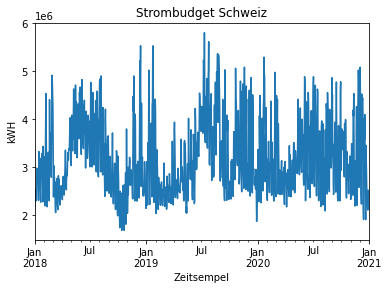

In [8]:
data['Strombudget Schweiz'].plot.line(ylabel='kWH', title='Strombudget Schweiz')

<AxesSubplot:xlabel='Zeitsempel'>

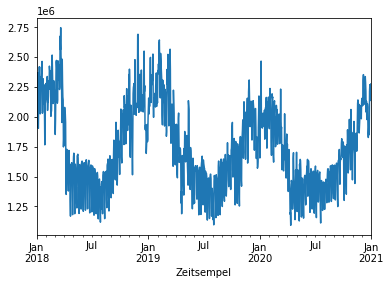

In [9]:
data['Stromverbrauch Schweiz'].plot.line()

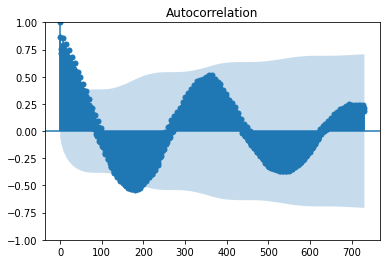

In [10]:
plot_acf(data['Stromverbrauch Schweiz'], lags=2*365)
plt.show()

<AxesSubplot:xlabel='Zeitsempel'>

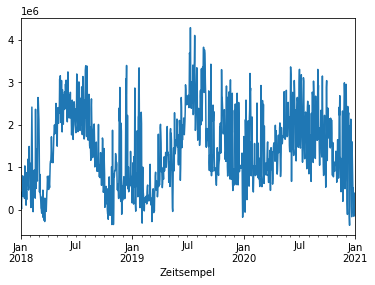

In [11]:
data['Strombilanz Schweiz'].plot.line()

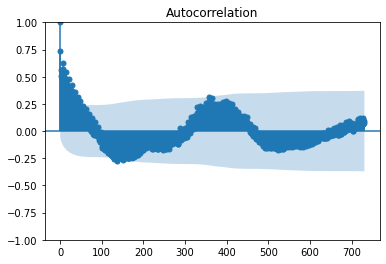

In [12]:
plot_acf(data['Strombilanz Schweiz'], lags=2*365)
plt.show()

Text(0.5, 1.0, 'Series vs. Lag 1')

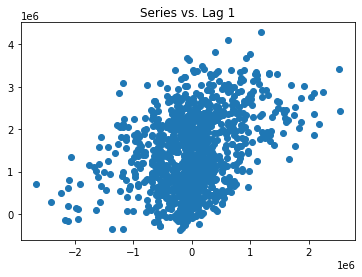

In [29]:
data['Strombilanz Schweiz lag 1'] = data['Strombilanz Schweiz'].shift(1)
data['Strombilanz - Lag 1'] = data['Strombilanz Schweiz'] - data['Strombilanz Schweiz lag 1']
data_ = data.dropna()
plt.scatter(data_['Strombilanz - Lag 1'], data_['Strombilanz Schweiz'])
plt.title('Series vs. Lag 1')

In [41]:
from sklearn.metrics import r2_score
from scipy import stats
r2_score(data_['Strombilanz Schweiz lag 1'], data_['Strombilanz Schweiz'])

0.4813924486699793

In [42]:
r2_scores = []
lags = []
corrs = []
for i in range(1, 2*365, 15):
    lags.append(i)
    data_tmp = data.copy()
    data_tmp['Strombilanz Schweiz Lag'] = data_tmp['Strombilanz Schweiz'].shift(i)
    data_tmp.dropna(inplace=True)
    r2_scores.append(r2_score(data_tmp['Strombilanz Schweiz Lag'], data_tmp['Strombilanz Schweiz']))
    corrs.append(stats.pearsonr(data_tmp['Strombilanz Schweiz Lag'], data_tmp['Strombilanz Schweiz'])[0])

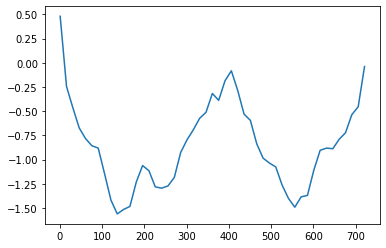

In [43]:
plt.plot(lags, r2_scores)

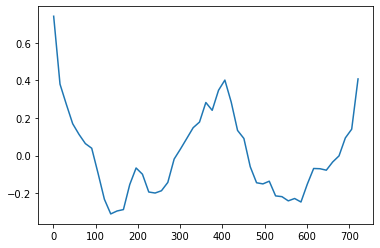

In [44]:
plt.plot(lags, corrs)

<AxesSubplot:>

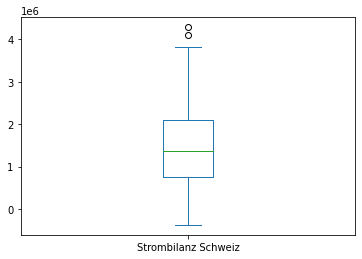

In [26]:
data_['Strombilanz Schweiz'].plot.box()

<AxesSubplot:ylabel='Frequency'>

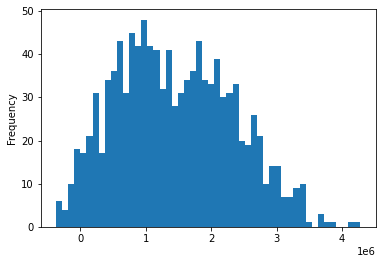

In [27]:
data_['Strombilanz Schweiz'].plot.hist(bins=50)

In [28]:
data_['Strombilanz Schweiz'].describe()

count    1.096000e+03
mean     1.445655e+06
std      8.904151e+05
min     -3.716868e+05
25%      7.668285e+05
50%      1.365178e+06
75%      2.088991e+06
max      4.281289e+06
Name: Strombilanz Schweiz, dtype: float64

In [47]:
data_below_0 = data.query('`Strombilanz Schweiz` < 0')
data_below_0

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz,Strombilanz Schweiz,Strombilanz Schweiz lag 1,Strombilanz - Lag 1
Zeitsempel,,,,,,,,,,
2018-02-11,1.648938e+06,1.296250e+06,1.940727e+06,581784.039431,8.833816e+05,2.179632e+06,2.230722e+06,-51089.646431,8.004545e+04,-1.311351e+05
2018-03-11,1.536375e+06,1.196182e+06,1.844572e+06,605123.701523,8.626421e+05,2.058824e+06,2.141499e+06,-82674.723195,1.349975e+04,-9.617447e+04
2018-03-12,1.946144e+06,1.437964e+06,2.068224e+06,522331.254617,9.427717e+05,2.380735e+06,2.468475e+06,-87739.277259,-8.267472e+04,-5.064554e+03
2018-03-14,1.861241e+06,1.437304e+06,2.025980e+06,538812.605499,8.836382e+05,2.320943e+06,2.400053e+06,-79110.782499,3.010614e+05,-3.801722e+05
2018-03-16,1.841797e+06,1.367841e+06,2.010781e+06,594985.820011,8.819264e+05,2.249767e+06,2.436783e+06,-187015.489211,4.564625e+05,-6.434780e+05
2018-03-17,1.683053e+06,1.311312e+06,1.909768e+06,545132.798846,8.881018e+05,2.199414e+06,2.228186e+06,-28772.327846,-1.870155e+05,1.582432e+05
2018-03-18,1.623906e+06,1.251945e+06,1.932782e+06,624238.017771,8.665253e+05,2.118471e+06,2.248144e+06,-129672.992338,-2.877233e+04,-1.009007e+05
2018-03-19,2.016229e+06,1.448346e+06,2.132418e+06,658782.455362,9.733126e+05,2.421658e+06,2.675012e+06,-253353.271325,-1.296730e+05,-1.236803e+05
2018-03-21,2.045024e+06,1.483448e+06,2.205642e+06,701184.154771,9.799529e+05,2.463400e+06,2.746209e+06,-282808.147475,2.647259e+05,-5.475341e+05


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


analysis = data[['Strombilanz Schweiz']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [45]:
train, test = train_test_split(data['Stromverbrauch Schweiz'], test_size = 0.5)
model = pm.auto_arima(train, seasonal=True, m=365)

KeyboardInterrupt: 

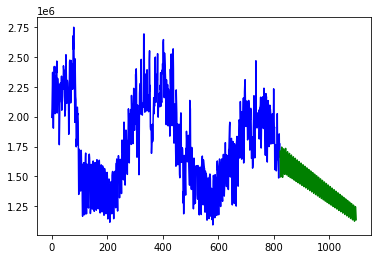

In [ ]:
# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(data['Stromverbrauch Schweiz'].shape[0])
plt.plot(x[:len(train)], train, c='blue')
plt.plot(x[len(train):], forecasts, c='green')
plt.show()